In [1]:
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import date
from datetime import timedelta
import requests
from matplotlib import rcParams
import os
import json
from matplotlib import rcParams
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
import plotly.graph_objects as go
import plotly.express as px

import sys
sys.path.append("C:/Users/eric_/Projects/mgc_data_app/")

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

%load_ext autoreload
%autoreload 2


In [3]:
# Import Custom Libraries
from utils.utils import *

In [4]:
data = pd.read_csv("../data/api.transaction (9).csv")

In [5]:
data.lastTransitionedAt = pd.to_datetime(data.lastTransitionedAt)

In [6]:
data.createdAt.max()

'2022-05-30 13:52:47.136753+00:00'

In [7]:
data['istransaction'] = data.lastTransition.apply(lambda x : map_transaction(x))

Text(0.5, 1.0, 'Transaction Per Month')

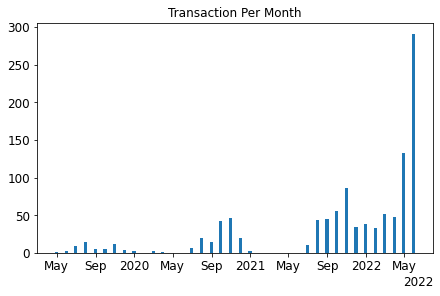

In [12]:
fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
#formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.bar(transac_by_date.lastTransitionedAt,transac_by_date.istransaction, width = 10)
ax.set_title('Transaction Per Month')

## PARCOURS CLIENT

In [13]:
import ast

In [14]:
data.transitions = data.transitions.apply(lambda x:ast.literal_eval(x))

In [15]:
data_expl = data.explode('transitions')

In [16]:
def get_histo_transition(transition):
    ''' transition as a dictionnary, get by and transition informations'''
    if isinstance(transition,dict):
        return transition['~:by'].replace('~:','') +' | ' + transition['~:transition'].replace('transition/','')
    else :
        return None

In [17]:
def get_histo_transition_date(transition):
    ''' transition as a dictionnary, get date information'''
    if isinstance(transition,dict):
        return transition['~:createdAt'].replace('~t','')[:10]
    else :
        return None

In [18]:
def get_histo_transition_hour(transition):
    ''' transition as a dictionnary, get date information'''
    if isinstance(transition,dict):
        return transition['~:createdAt'].replace('~t','')[11:19]
    else :
        return None

In [19]:
data_expl['transition_step'] = data_expl.transitions.apply(lambda x:get_histo_transition(x)) 
data_expl['transition_step_date'] = data_expl.transitions.apply(lambda x:get_histo_transition_date(x)) 
data_expl['transition_step_hour'] = data_expl.transitions.apply(lambda x:get_histo_transition_hour(x)) 

In [20]:
data_expl.lastTransition = data_expl.lastTransition.apply(lambda x:x.replace('transition/',''))

In [21]:
data_expl.transition_step_date = pd.to_datetime(data_expl.transition_step_date)

In [22]:
data_expl = data_expl.reset_index().rename(columns = {'index':'transaction_num'})

In [23]:
encoded_transition = pd.get_dummies(data_expl.transition_step)

In [24]:
data_expl_dummies = data_expl.merge(encoded_transition,how='inner',left_index=True,right_index=True)

In [25]:
transitions = ['customer | confirm-payment',
 'customer | enquire',
 'customer | request-payment',
 'customer | request-payment-after-enquiry',
 'customer | review-1-by-customer',
 'customer | review-2-by-customer',
 'operator | cancel',
 'operator | decline',
 'provider | accept',
 'provider | decline',
 'provider | request-payment',
 'provider | review-1-by-provider',
 'provider | review-2-by-provider',
 'system | complete',
 'system | confirm-payment',
 'system | expire']

In [26]:
def get_transition_histo_details(data,key,freq,transition):
    by_freq = (pd.DataFrame(
                data.groupby(pd.Grouper(key = key,freq = freq))
                .sum()
                [transition]
                )
                .reset_index()
                .melt(id_vars=[key])
                .rename(columns={'variable':'transition'})
                )
    return by_freq

In [27]:
def plot_transition_histo_details(key,freq,transition):
    data = data_expl_dummies
    by_freq = get_transition_histo_details(data,key,freq,transition)
    fig = px.bar(by_freq, x=key, y = 'value')
    fig.show()

In [28]:
def interactive_plot_transition_histo_details(data,key):       
    interact_manual(plot_transition_histo_details, key = key, freq = ['d','w','m','y'] , transition = transitions)

In [29]:
interactive_plot_transition_histo_details(data_expl_dummies, key = 'transition_step_date')

interactive(children=(Text(value='transition_step_date', description='key'), Dropdown(description='freq', options=('d', 'w', 'm', 'y'), value='d'), Dropdown(description='transition', options=('customer | confirm-payment', 'customer | enquire', 'customer | request-payment', 'customer | request-payment-after-enquiry', 'customer | review-1-by-customer', 'customer | review-2-by-customer', 'operator | cancel', 'operator | decline', 'provider | accept', 'provider | decline', 'provider | request-payment', 'provider | review-1-by-provider', 'provider | review-2-by-provider', 'system | complete', 'system | confirm-payment', 'system | expire'), value='customer | confirm-payment'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [30]:
def value_counts_of_X_by_Y(dataframe,X,Y):
    '''
    Returns value counts of column X by values of Y
    '''
    temp = (pd.DataFrame(
            pd.crosstab(dataframe[Y],dataframe[X])
        .ne(0)
        .sum(1)
        .sort_values(ascending = False))
           )
    temp = temp.rename(columns={0:'count'})
    temp ['proportion'] = temp['count']/dataframe[X].nunique()
    temp = temp.style.format({'proportion': "{:.1%}"}).bar(subset='count',width = 80,vmin=0)
    return temp

In [31]:
#pd.crosstab(data_expl.transition_step,data_expl.lastTransition).to_csv('analyse_croisée_parcoursclient.csv')

In [32]:
data['month_transition'] = data.lastTransitionedAt.dt.month
data['year_transition'] = data.lastTransitionedAt.dt.year
data['day_transition'] = data.lastTransitionedAt.dt.day

## Listings and Profiles merges

In [33]:
data_expl_dummies

,transaction_num,id,state,process,booking,createdAt,customer,lastTransition,lastTransitionedAt,lastModifiedAt,...,operator | cancel,operator | decline,provider | accept,provider | decline,provider | request-payment,provider | review-1-by-provider,provider | review-2-by-provider,system | complete,system | confirm-payment,system | expire
0,0,93b9f3eb-ec9a-4b70-96d4-8463083d80c8,enquiry,mygoldencloset/beta,NaN,2022-05-30 13:52:47.136753+00:00,Marine D | m.devasselot86@gmail.com,enquire,2022-05-30 13:52:47.136895+00:00,2022-05-30 14:39:30.513048+00:00,...,0,0,0,0,0,0,0,0,0,0
1,1,ed602165-2e51-4a5a-b88f-f11c6a1befe9,enquiry,mygoldencloset/beta,NaN,2022-05-30 13:35:36.064104+00:00,Elisabeth C | elisabethcesbronlavau@gmail.com,enquire,2022-05-30 13:35:36.064243+00:00,2022-05-30 13:35:36.204769+00:00,...,0,0,0,0,0,0,0,0,0,0
2,2,7f03e09f-01a7-4032-9613-2c06c03c8cff,enquiry,mygoldencloset/beta,NaN,2022-05-30 12:46:14.058636+00:00,Camille G | camille.guillot45@yahoo.fr,enquire,2022-05-30 12:46:14.058818+00:00,2022-05-30 12:53:45.023293+00:00,...,0,0,0,0,0,0,0,0,0,0
3,3,60634c26-7558-49a9-a20d-029dfdef833d,accepted,mygoldencloset/beta,957a57f7-b37e-4a85-b911-6a113e46f424,2022-05-30 11:25:23.091225+00:00,Victoire C | victoire97.carmantrand@orange.fr,accept,2022-05-30 11:58:25.304049+00:00,2022-05-30 11:59:23.516209+00:00,...,0,0,0,0,0,0,0,0,0,0
4,3,60634c26-7558-49a9-a20d-029dfdef833d,accepted,mygoldencloset/beta,957a57f7-b37e-4a85-b911-6a113e46f424,2022-05-30 11:25:23.091225+00:00,Victoire C | victoire97.carmantrand@orange.fr,accept,2022-05-30 11:58:25.304049+00:00,2022-05-30 11:59:23.516209+00:00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7715,3939,5cb7358f-83b8-40af-8c30-ba3e52b52748,enquiry,mygoldencloset/beta,NaN,2019-04-17 14:17:51.335000+00:00,Alexandra D | a.doittau@orange.fr,enquire,2019-04-17 14:17:51.357000+00:00,2019-04-21 18:20:01.943000+00:00,...,0,0,0,0,0,0,0,0,0,0
7716,3940,5cb2f2fc-326d-4a98-8d2b-a2ef7febe680,reviewed,mygoldencloset/beta,5cb2f2fc-dd06-4f74-afee-e21d5a740b4e,2019-04-14 08:44:44.166000+00:00,Anne-cécile H | annececile.hulot@essec.edu,expire-provider-review-period,2019-04-27 00:00:14.256000+00:00,2019-04-27 00:00:14.256000+00:00,...,0,0,0,0,0,0,0,0,0,0
7717,3941,5cb258a0-db26-40f7-8778-eb3d664a13ae,declined,mygoldencloset/beta,5cb258a0-d9b3-426f-b485-0ff722910ca9,2019-04-13 21:46:08.521000+00:00,Amélie C | amelie.charbon@hotmail.fr,decline,2019-04-14 07:17:15.688000+00:00,2019-04-14 07:17:15.688000+00:00,...,0,0,0,0,0,0,0,0,0,0
7718,3942,5cb05a26-093e-43b3-8f51-cae81a750ff5,reviewed,mygoldencloset/beta,5cc7ff20-ea36-4c3c-8e5e-c8559a1f3d40,2019-04-12 09:28:06.688000+00:00,Priscille L | priscille.loubert@gmail.com,expire-review-period,2019-07-07 00:00:07.886000+00:00,2019-07-07 00:00:07.886000+00:00,...,0,0,0,0,0,0,0,0,0,0


In [34]:
listings = pd.read_csv("./data/api.listing.csv")

In [35]:
profiles = pd.read_csv("./data/api.profile.csv")

In [36]:
data[['listing_name','listing_id']] = data.listing.str.split('|', 1, expand=True)
data.listing_id = data.listing_id.apply(lambda x:x.replace(" ","")) 

In [37]:
data[['customer_name','customer_email']] = data.customer.str.split('|', 1, expand=True)
data.customer_email = data.customer_email.apply(lambda x:x.replace(" ","")) 
data[['provider_name','provider_email']] = data.provider.str.split('|', 1, expand=True)
data.provider_email = data.provider_email.apply(lambda x:x.replace(" ","")) 

In [38]:
transac_listing = data.merge(listings,how='left',left_on = 'listing_id',right_on = 'id',suffixes=('_transac','_listings'))

In [39]:
full_data_transac = transac_listing.merge(profiles,how='left',left_on = 'customer_email',right_on='email').merge(profiles,how='left',left_on = 'provider_email',right_on='email',suffixes=('_loc','_prop'))

In [41]:
full_data_w_transaction = full_data_transac[full_data_transac.istransaction == 1]
full_data_wo_transaction = full_data_transac[full_data_transac.istransaction != 1]

## Customer stats

In [43]:
full_data_w_transaction.groupby(['first_name_loc','last_name_loc']).count()['id_transac'].sort_values(ascending=False).head(40)

first_name_loc  last_name_loc       
Anne-Cécile     HULOT                   30
Constance       Lefèvre                  8
Emma            Blanche                  8
Marion          Paget                    7
Julia           Roure                    7
Tara            Polderman                6
Priscille       Loubert                  6
Clemence        Lepine                   6
Marie Alix      Gourvès                  5
Marguerite      d'Allemagne              5
Daphné          Gaillard                 5
Florence        Cosson                   5
Quitterie       d'Andoque                4
Ines            Rougevin-Baville         4
alizée          falandry                 4
Diane           Cbt                      4
Guénola         Quirouard - Frileuse     4
Émilie          Daeschler                4
Pauline         Peigné                   4
Gersende        Buckel                   4
Marguerite      DC                       4
                Musnier                  4
Albane          d

In [44]:
customer_sales = profiles.merge(data, how='left', left_on = 'email', right_on = 'customer_email')

In [45]:
conversion_locataires = (full_data_transac.groupby(['first_name_loc','last_name_loc'])
                    .agg({'id_transac':'count',
                     'istransaction':'sum'})
                   .rename(columns={'id_transac':'transaction_commencée'})
                    .sort_values(by='transaction_commencée',ascending=False)
)
conversion_locataires['conversion'] = conversion_locataires['istransaction']/conversion_locataires['transaction_commencée']
conversion_locataires = conversion_locataires.reset_index()

In [46]:
conversion_locataires.melt(id_vars=['first_name_loc','last_name_loc'])

,first_name_loc,last_name_loc,variable,value
0,Anne-Cécile,HULOT,transaction_commencée,63.0
1,Priscille,Loubert,transaction_commencée,53.0
2,Ombeline,de Sachy,transaction_commencée,33.0
3,Channel,Luvanga,transaction_commencée,29.0
4,Jeanne,de Sérésin,transaction_commencée,27.0
...,...,...,...,...
4426,Gaelle,Benezeth,conversion,0.0
4427,Gaétane,De valbray,conversion,1.0
4428,Gaëlle,Collin,conversion,1.0
4429,Gaëlle,Fleury,conversion,1.0


In [47]:
fig = px.histogram(conversion_locataires.melt(id_vars=['first_name_loc','last_name_loc']), x="value", color="variable", 
                   facet_col="variable")
fig.show()

In [48]:
conversion_locataires.conversion = conversion_locataires.conversion.apply(lambda x:round(x,1)*100) 

In [49]:
col_proportion(conversion_locataires,'conversion')

,conversion,proportion
0.0,734,49.7%
100.0,320,21.7%
50.0,157,10.6%
30.0,84,5.7%
20.0,78,5.3%
10.0,35,2.4%
70.0,33,2.2%
40.0,22,1.5%
60.0,7,0.5%
80.0,5,0.3%


In [50]:
fig = px.histogram(conversion_locataires, x="conversion", marginal="rug",
                   hover_data=conversion_locataires.columns)
fig.show()

In [51]:
fig = px.histogram(conversion_locataires, x="transaction_commencée", marginal="rug",
                   hover_data=conversion_locataires.columns)
fig.show()

In [52]:
funnel = (data_expl_dummies.groupby('customer')
                    .agg({'customer | confirm-payment':'sum',
                          'customer | enquire':'sum',
                          'customer | request-payment':'sum',
                          'customer | request-payment-after-enquiry':'sum',
                          'customer | review-1-by-customer':'sum',
                          'customer | review-2-by-customer':'sum',
                          'operator | cancel':'sum',
                          'operator | decline':'sum',
                          'provider | accept':'sum',
                          'provider | decline':'sum',
                          'provider | request-payment':'sum',
                          'provider | review-1-by-provider':'sum',
                          'provider | review-2-by-provider':'sum',
                          'system | complete':'sum',
                          'system | confirm-payment':'sum',
                          'system | expire':'sum'
                         })
                   .rename(columns={'istransaction':'istransaction'})
                    .sort_values(by='provider | accept',ascending=False)
)

In [53]:
funnel_melt = funnel.reset_index().melt(id_vars = 'customer')

In [54]:
fig = px.histogram(funnel_melt, x="value", color="variable", 
                   facet_col="variable")
fig.show()

In [55]:
#funnel.to_csv("funnel.csv")

## Articles wishlistés

In [56]:
#data[['month_transition','year_transition','lastTransition','istransaction']].groupby(['year_transition','month_transition','lastTransition']).agg({'lastTransition':'count'}).to_csv("decline.csv")

In [57]:
def get_latest_best_listings(nb_last_days):
    temp = full_data_w_transaction.copy()
    today = temp.lastTransitionedAt.max()
    temp['is_latest'] = temp.apply(lambda x: (today - x.lastTransitionedAt) < timedelta(days=nb_last_days),axis = 1)
    temp = temp[temp['is_latest']==True]
    return temp.groupby(['listing_name']).count()['id_transac'].sort_values(ascending=False).head(40)

In [58]:
def interactive_get_latest_best_listings():       
    interact_manual(get_latest_best_listings, nb_last_days=(0,500))

In [59]:
interactive_get_latest_best_listings()

interactive(children=(IntSlider(value=250, description='nb_last_days', max=500), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [ ]:
full_data_w_transaction.date_joined_loc = pd.to_datetime(full_data_w_transaction.date_joined_loc)

<AxesSubplot:xlabel='date_joined_loc'>

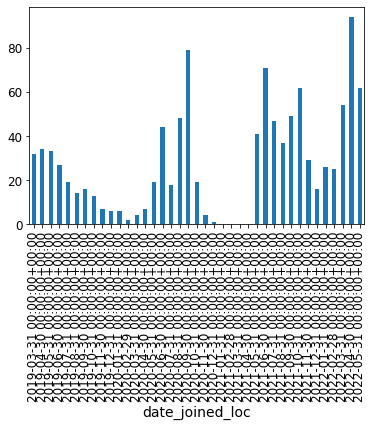

In [144]:
(full_data_w_transaction.groupby(pd.Grouper(key='date_joined_loc',freq='m')).count())['id_transac'].plot(kind='bar')

In [119]:
full_data_w_transaction.groupby(['first_name_prop','last_name_prop']).count()['id_transac'].sort_values(ascending=False).head(40)

first_name_prop  last_name_prop
Amélie           de Champs         129
Madeleine        Ispari             93
Anne-Cécile      HULOT              67
Clara            de Bisschop        29
Diane            Cbt                28
Véronique        Vache              19
Amélie           Charbon            15
Claire           Ponroy             15
Daphné           Livet              13
Marine           Broine             11
Emilie           BLANCHY            10
Marion           Mahiu               9
Maïlys           Lanata              9
Coralie          LEBIGOT             9
Amélie           Maleval             8
Gersende         Buckel              8
Albane           Duval               8
Clémence         Delebecq            8
Maguelonne       Lecointre           8
Cassandre        d'Ep                8
Domitille        de Maillard         7
Camille          Mauron              7
Maxoushka        Le Gars             7
Victoria         Chambreuil          6
Lauriane         Debats         

## Date Joined

In [120]:
profiles.date_joined = pd.to_datetime(profiles.date_joined)
acquisition_by_date = (profiles.groupby(pd.Grouper(key='date_joined',freq='m'))
                       .agg({'id':'count',
                             'emailVerified':'sum',
                             'stripeAccount':'count',
                             'phoneNumber':'count'})
                       .rename(columns={'id':'new_user'})
                      )
acquisition_by_date = pd.DataFrame(acquisition_by_date).reset_index()
for column in acquisition_by_date.columns:
    if column not in ['new_user','date_joined']:
        acquisition_by_date[column] = round(acquisition_by_date[column] / acquisition_by_date['new_user'],1)
acquisition_by_date_style = acquisition_by_date.fillna(0).tail(8).style.format({
    'emailVerified': '{:,.0%}'.format,
    'stripeAccount': '{:,.0%}'.format,
    'phoneNumber':'{:,.0%}'.format
})

In [121]:
acquisition_by_date_style

,date_joined,new_user,emailVerified,stripeAccount,phoneNumber
31,2021-10-31 00:00:00+00:00,177,80%,40%,20%
32,2021-11-30 00:00:00+00:00,195,80%,20%,10%
33,2021-12-31 00:00:00+00:00,87,70%,20%,10%
34,2022-01-31 00:00:00+00:00,131,80%,20%,10%
35,2022-02-28 00:00:00+00:00,152,80%,20%,10%
36,2022-03-31 00:00:00+00:00,230,80%,30%,10%
37,2022-04-30 00:00:00+00:00,375,80%,20%,10%
38,2022-05-31 00:00:00+00:00,372,80%,20%,0%


In [122]:
fig = px.bar(acquisition_by_date, x=acquisition_by_date.date_joined, y='new_user')
fig.show()

In [79]:
full_data_w_transaction['month_joined'] = full_data_w_transaction.lastTransitionedAt.dt.month
full_data_w_transaction['year_joined'] = full_data_w_transaction.lastTransitionedAt.dt.year

C:\Users\eric_\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\eric_\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
full_data_w_transaction['city']=full_data_w_transaction['address'].apply(lambda x : x.split(",")[-3] if len(x.split(","))>2 else '')

C:\Users\eric_\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
full_data_w_transaction.groupby(['city']).count()['id_transac'].sort_values(ascending=False).head(40)

city
                                      593
 75116 Paris                           88
 Paris                                 61
 75015 Paris                           57
 75017 Paris                           19
 75003 Paris                           16
 75005 Paris                           14
 75009 Paris                           12
 Hauts-de-Seine                        11
 75016 Paris                           11
 75012 Paris                           10
 75007 Paris                            9
 92300 Levallois-Perret                 8
 75006 Paris                            8
 44300 Nantes                           8
 78220 Viroflay                         7
 Yvelines                               7
 92100 Boulogne-Billancourt             7
 93270 Sevran                           7
 92200 Neuilly-sur-Seine                7
 49100 Angers                           6
 75013 Paris                            5
 69002 Lyon                             4
 75014 Paris                 

In [82]:
full_data_w_transaction

,id_transac,state_transac,process,booking,createdAt_transac,customer,lastTransition,lastTransitionedAt,lastModifiedAt,lastActivity,...,avatar_prop,stripeAccount_prop,bio_prop,email_prop,emailVerified_prop,phoneNumber_prop,wishlist_prop,month_joined,year_joined,city
5,e3a73b05-0b9c-4405-91b1-e3fb798676bb,accepted,mygoldencloset/beta,11283f71-b487-402e-be0a-2bf4fedcdcee,2022-05-25 09:24:13.101895+00:00,Alix P | pommieralix@gmail.com,transition/accept,2022-05-25 09:24:32.008804+00:00,2022-05-25 09:27:17.761661+00:00,Tu verras il est super 😍,...,ecc989e8-3341-4073-8d94-ac2d7f051628,StripeAccount object (d80a2048-b91b-495c-a7f3-...,NaN,louise.voiseux@outlook.com,True,NaN,[],5,2022,
7,c7fafc45-68e0-4ddb-89d6-81cc495f30d4,accepted,mygoldencloset/beta,335bb055-8b33-46ef-8f86-1e2f675ab901,2022-05-25 08:14:47.066462+00:00,Elisabeth H | e.huynh53@gmail.com,transition/accept,2022-05-25 08:17:04.646125+00:00,2022-05-25 08:17:04.646125+00:00,Super belle !,...,5ce29e90-ef6f-4a12-a446-b7042b23464f,StripeAccount object (81e9b0e9-84df-4e4d-9f6a-...,NaN,annececile.hulot@essec.edu,True,+33777365338,"[UUID('5f6ccaee-7e88-47f6-9858-c585acbcb911'),...",5,2022,
11,eade1bec-ac6c-4534-bf30-43345b8d9641,accepted,mygoldencloset/beta,be815b26-72e6-49cc-b6fd-7dc21b29d0da,2022-05-24 21:40:28.578247+00:00,Alix P | pommieralix@gmail.com,transition/accept,2022-05-25 04:57:37.361594+00:00,2022-05-25 09:24:57.436682+00:00,je viens de faire la manip :) merci beaucoup :),...,ecc989e8-3341-4073-8d94-ac2d7f051628,StripeAccount object (d80a2048-b91b-495c-a7f3-...,NaN,louise.voiseux@outlook.com,True,NaN,[],5,2022,
12,da8c36dc-1663-476f-8b3c-e6aff75e2fa5,accepted,mygoldencloset/beta,960361c4-779c-4f0d-9010-d80716ce0f7c,2022-05-24 21:11:06.380099+00:00,Fanny B | fberland94@gmail.com,transition/accept,2022-05-24 21:19:40.553460+00:00,2022-05-25 09:41:40.658031+00:00,Ce sera shop2shop via chronopost a priori!,...,5ed1029b-89bd-4d64-87de-8310e22a9c65,StripeAccount object (e958cee4-b4eb-45b7-91e5-...,Hello !\nParisienne d'adoption et dingue de te...,dechampsamelie@yahoo.fr,True,+33646162482,"[UUID('77ed29c9-6af1-41ca-9b75-1841b9e8427d'),...",5,2022,75116 Paris
17,ff86bc5a-403b-4fe4-b5c1-c6ea94fe50fb,delivered,mygoldencloset/beta,d3e7064b-2a73-4dac-927c-f61f3d47366d,2022-05-24 18:17:38.300160+00:00,Victoria I | victoriaivins@hotmail.com,transition/complete,2022-05-25 06:00:35.084839+00:00,2022-05-25 06:00:35.084839+00:00,Bonjour!,...,5ce29e90-ef6f-4a12-a446-b7042b23464f,StripeAccount object (81e9b0e9-84df-4e4d-9f6a-...,NaN,annececile.hulot@essec.edu,True,+33777365338,"[UUID('5f6ccaee-7e88-47f6-9858-c585acbcb911'),...",5,2022,Paris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,5cd40716-9b07-4ee6-b1a9-39c242e32d65,reviewed,mygoldencloset/beta,5cd83f0f-bdf6-4ad1-95fd-26d29faab7e8,2019-05-09 10:55:18.737000+00:00,Flavie H | flavie13@yahoo.fr,transition/review-2-by-customer,2019-05-24 11:36:11.711000+00:00,2019-05-24 11:36:11.711000+00:00,"Bonjour Flavie, peut on plutôt se retrouver de...",...,260c1be2-1b48-4025-ba5f-c4bf88768a9a,StripeAccount object (b31a252f-26c3-40ff-aeb2-...,Bienvenue dans mon dressing ! \n\nJe m'appell...,dom.2maillard@orange.fr,True,0626112254,"[UUID('5cee7189-5a48-40eb-a86d-be375c5f3f71'),...",5,2019,75003 Paris
3863,5cd33e4e-fe7e-4c72-903b-c190125a9c83,reviewed,mygoldencloset/beta,5cd33e4f-164b-408a-877e-c02a419524cb,2019-05-08 20:38:38.989000+00:00,Anne-cécile H | annececile.hulot@essec.edu,transition/expire-provider-review-period,2019-05-26 00:00:12.581000+00:00,2019-06-03 19:37:24.652000+00:00,Je vois seulement ton petit commentaire trop m...,...,5cac4376-c518-4dcd-a064-8ff555f9e1f0,StripeAccount object (de8e4686-081b-47e7-8730-...,"Bonjour, je m'appelle Amélie, je propose à la ...",amelie.charbon@hotmail.fr,True,0616245891,[],5,2019,75005 Paris
3875,5cbcbd0a-77c0-46b4-badc-d816a09d83b5,reviewed,mygoldencloset/beta,5cbd7ddf-9aeb-481c-a7aa-06ce4212f157,2019-04-21 18:57:14.306000+00:00,Solenn D | solenndpy@h

In [83]:
profiles.date_joined = pd.to_datetime(profiles.date_joined)

<AxesSubplot:xlabel='date_joined'>

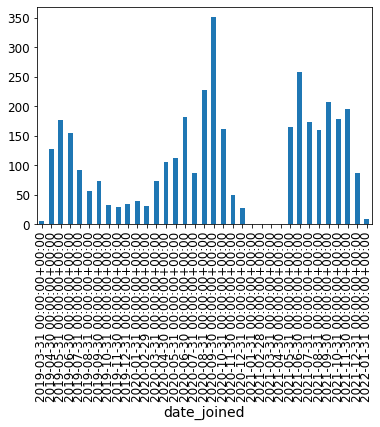

In [84]:
profiles.groupby(pd.Grouper(key='date_joined',freq='m')).count()['id'].plot(kind='bar')

In [85]:
data_transac = data[data.istransaction == 1]

# Profile Card

In [86]:
def count_by_name(data):
    column = list(data.columns)[-1]
    output = data.groupby(['id']).count().sort_values(by=column,ascending=False)[column]
    return pd.DataFrame(output).reset_index()

In [87]:
activity_per_profile = count_by_name(profiles.merge(data,how='left',left_on = 'id',right_on = 'id')).rename(columns={'day_transition':'count_activity'})

In [88]:
transac_per_profile = count_by_name(profiles.merge(data_transac,how='left',left_on = 'id',right_on = 'provider_id')).rename(columns={'day_transition':'count_transac'})

KeyError: 'provider_id'

In [89]:
transac_date_stats = (profiles
                 .merge(data_transac,how='left',left_on = 'id',right_on = 'provider_id')
                 .groupby('id_x')
                 .agg({'lastTransitionedAt': [np.min,np.max]})
                )
transac_date_stats = transac_date_stats.transpose().reset_index().drop(columns = 'level_0').transpose()
transac_date_stats.columns = transac_date_stats.iloc[0]
transac_date_stats = transac_date_stats.drop(index='level_1').reset_index()

KeyError: 'provider_id'

In [ ]:
profile_stats = (profiles
                 .merge(activity_per_profile,how='left',left_on = 'id',right_on = 'id_x')
                 .merge(transac_per_profile,how='left',left_on = 'id',right_on = 'id_x')
                 .merge(transac_date_stats,how='left',left_on = 'id',right_on = 'index')
                )

In [ ]:
profile_stats.columns

In [ ]:
profile_stats_light = profile_stats[['first_name','last_name','date_joined','count_activity','count_transac','amin','amax']]

In [ ]:
profile_stats_light.amin = pd.to_datetime(profile_stats_light.amin).dt.date
profile_stats_light.amax = pd.to_datetime(profile_stats_light.amax).dt.date
profile_stats_light.date_joined = pd.to_datetime(profile_stats_light.date_joined).dt.date

In [ ]:
profile_stats_light['time_to_transac'] = (profile_stats_light.amin - profile_stats_light.date_joined).dt.days
profile_stats_light['time_btw_transac'] = (profile_stats_light.amax - profile_stats_light.amin).dt.days

In [ ]:
profile_stats_light.to_excel("")

In [ ]:
col_proportion(profile_stats_light,'count_activity')

In [ ]:
col_proportion(profile_stats_light,'count_transac')

In [ ]:
col_proportion(profile_stats_light[profile_stats_light.count_activity != 0],'count_transac')

In [ ]:
col_proportion(profile_stats_light[profile_stats_light.count_transac == 0],'count_activity')

In [ ]:
col_proportion(profile_stats_light,'time_to_transac',max_occurences=1000)

In [ ]:
profile_stats_light.date_joined.dt.month

In [ ]:
profile_stats_light['month_joined'] = profile_stats_light.date_joined.dt.month
profile_stats_light['year_joined'] = profile_stats_light.date_joined.dt.year